In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, get_linear_schedule_with_warmup
from datasets import Dataset
from statsmodels.tsa.arima.model import ARIMA
import re
import logging
 
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kisla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
df = pd.read_csv("amazon_reviews.csv")

df.dropna(subset=['review'], inplace=True)

def assign_sentiment(rating):
    if rating >= 4:
        return 1  # Positive
    elif rating == 3:
        return 0  # Neutral
    else:
        return -1  # Negative

df['sentiment'] = df['rating'].apply(assign_sentiment)

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = [word for word in text.split() if word.isalpha() and word not in stop_words]
    return ' '.join(words)

df['cleaned_review'] = df['review'].apply(preprocess_text)

print(df.head())


         asin                                     name        date  rating  \
0  B07W7CTLD1  Mamaearth-Onion-Growth-Control-Redensyl  2019-09-06       1   
1  B07W7CTLD1  Mamaearth-Onion-Growth-Control-Redensyl  2019-08-14       5   
2  B07W7CTLD1  Mamaearth-Onion-Growth-Control-Redensyl  2019-10-19       1   
3  B07W7CTLD1  Mamaearth-Onion-Growth-Control-Redensyl  2019-09-16       1   
4  B07W7CTLD1  Mamaearth-Onion-Growth-Control-Redensyl  2019-08-18       5   

                                              review  sentiment  \
0  I bought this hair oil after viewing so many g...         -1   
1  Used This Mama Earth Newly Launched Onion Oil ...          1   
2  So bad product...My hair falling increase too ...         -1   
3  Product just smells similar to navarathna hair...         -1   
4  I have been trying different onion oil for my ...          1   

                                      cleaned_review  
0  bought hair oil viewing many good comments pro...  
1  used mama earth

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
df['bert_sentiment'] = df['sentiment'].apply(lambda x: 0 if x == -1 else x)
hf_dataset = Dataset.from_pandas(df[['cleaned_review', 'bert_sentiment']])

def tokenize_function(examples):
    return tokenizer(examples['cleaned_review'], padding="max_length", truncation=True, max_length=128)

hf_dataset = hf_dataset.map(tokenize_function, batched=True, remove_columns=['cleaned_review'])
hf_dataset = hf_dataset.rename_column("bert_sentiment", "labels")
hf_dataset = hf_dataset.train_test_split(test_size=0.2)

print(hf_dataset)


Map:   0%|          | 0/2776 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2220
    })
    test: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 556
    })
})


In [10]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    report = classification_report(labels, preds)
    print("Classification Report:\n", report)
    
    return {
        'accuracy': accuracy_score(labels, preds),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset["train"],
    eval_dataset=hf_dataset["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)
trainer.train()


d:\Hub\MLmodel\venv\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\kisla\AppData\Local\Temp\ipykernel_14088\2599844887.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/834 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.91      0.81       186
           1       0.95      0.83      0.88       370

    accuracy                           0.86       556
   macro avg       0.84      0.87      0.85       556
weighted avg       0.87      0.86      0.86       556

{'eval_loss': 0.34795987606048584, 'eval_accuracy': 0.8561151079136691, 'eval_runtime': 132.0338, 'eval_samples_per_second': 4.211, 'eval_steps_per_second': 0.53, 'epoch': 1.0}
{'loss': 0.3851, 'grad_norm': 0.9073243737220764, 'learning_rate': 8.00959232613909e-06, 'epoch': 1.8}


  0%|          | 0/70 [00:00<?, ?it/s]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       186
           1       0.94      0.95      0.95       370

    accuracy                           0.93       556
   macro avg       0.93      0.92      0.92       556
weighted avg       0.93      0.93      0.93       556

{'eval_loss': 0.2740797996520996, 'eval_accuracy': 0.9316546762589928, 'eval_runtime': 128.9891, 'eval_samples_per_second': 4.31, 'eval_steps_per_second': 0.543, 'epoch': 2.0}


  0%|          | 0/70 [00:00<?, ?it/s]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92       186
           1       0.94      0.98      0.96       370

    accuracy                           0.95       556
   macro avg       0.95      0.93      0.94       556
weighted avg       0.95      0.95      0.95       556

{'eval_loss': 0.2576769292354584, 'eval_accuracy': 0.947841726618705, 'eval_runtime': 131.1076, 'eval_samples_per_second': 4.241, 'eval_steps_per_second': 0.534, 'epoch': 3.0}
{'train_runtime': 6750.2407, 'train_samples_per_second': 0.987, 'train_steps_per_second': 0.124, 'train_loss': 0.2829387079325797, 'epoch': 3.0}


TrainOutput(global_step=834, training_loss=0.2829387079325797, metrics={'train_runtime': 6750.2407, 'train_samples_per_second': 0.987, 'train_steps_per_second': 0.124, 'total_flos': 438083840517120.0, 'train_loss': 0.2829387079325797, 'epoch': 3.0})

In [11]:
batch_size = 32
results = []

for i in range(0, len(df), batch_size):
    batch = df['cleaned_review'][i:i + batch_size].tolist()
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    results.extend(predictions)

df['bert_sentiment'] = results

print(df[['cleaned_review', 'bert_sentiment']].head())



Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using devi

In [12]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\kisla\AppData\Local\Temp\ipykernel_14088\2278575511.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


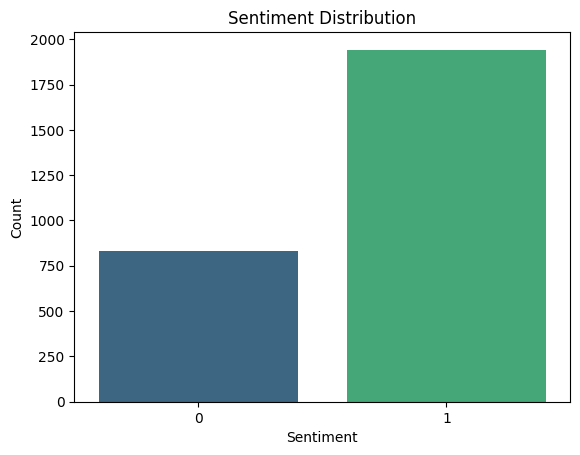

In [13]:
sentiment_counts = df['bert_sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


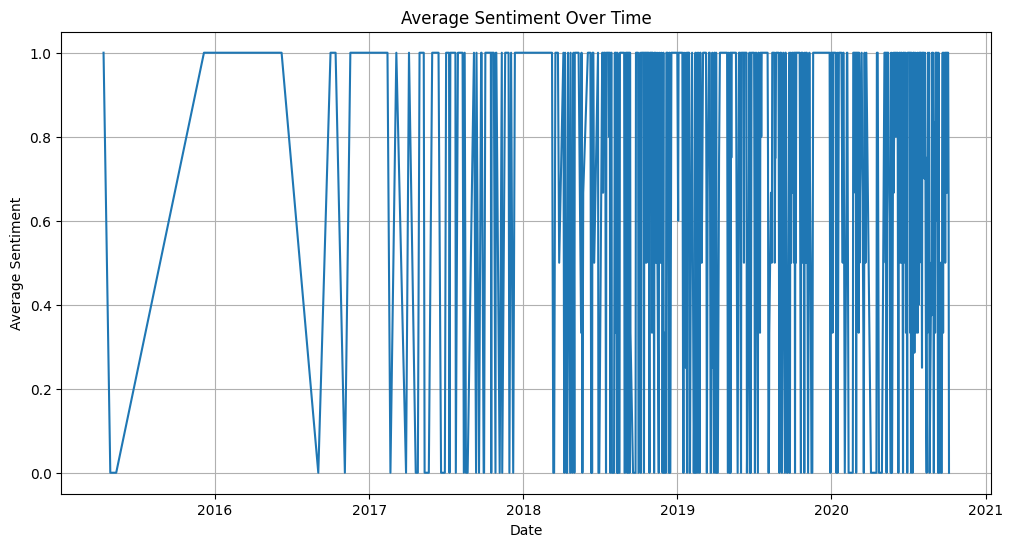

d:\Hub\MLmodel\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Hub\MLmodel\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Hub\MLmodel\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         bert_sentiment   No. Observations:                  686
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -361.734
Date:                Sun, 01 Dec 2024   AIC                            729.467
Time:                        19:06:56   BIC                            743.055
Sample:                             0   HQIC                           734.725
                                - 686                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0341      0.038      0.906      0.365      -0.040       0.108
ma.L1         -0.9999      0.316     -3.161      0.002      -1.620      -0.380
sigma2         0.1668      0.055      3.025      0.0

d:\Hub\MLmodel\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Hub\MLmodel\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [14]:
df['date'] = pd.to_datetime(df['date'])

daily_sentiment = df.groupby('date')['bert_sentiment'].mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment.index, daily_sentiment.values)
plt.title("Average Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sentiment")
plt.grid()
plt.show()

arima_model = ARIMA(daily_sentiment, order=(1, 1, 1))
arima_result = arima_model.fit()
print(arima_result.summary())

forecast = arima_result.forecast(steps=10)
print("Forecasted Sentiments:", forecast)


In [15]:
# 1. Statistical Analysis of Sentiments
sentiment_array = df['bert_sentiment'].values
print("Sentiment Statistics:")
print("Mean Sentiment:", np.mean(sentiment_array))
print("Median Sentiment:", np.median(sentiment_array))
print("Standard Deviation:", np.std(sentiment_array))

# 2. Binning Sentiments
sentiment_bins = np.histogram(df['bert_sentiment'], bins=3)
print("Sentiment Distribution Bins:", sentiment_bins)

# 3. Advanced Feature Engineering
def extract_review_length(reviews):
    """Calculate review lengths using NumPy"""
    return np.array([len(review.split()) for review in reviews])

df['review_length'] = extract_review_length(df['cleaned_review'])

# Correlation between review length and sentiment
length_sentiment_correlation = np.corrcoef(df['review_length'], df['bert_sentiment'])[0, 1]
print("Correlation between Review Length and Sentiment:", length_sentiment_correlation)

# 4. Random Sampling for Model Validation
np.random.seed(42)
random_sample_indices = np.random.choice(len(df), size=100, replace=False)
sample_reviews = df.iloc[random_sample_indices]

# 5. One-hot Encoding of Sentiments
sentiment_one_hot = np.eye(3)[df['bert_sentiment']]

Sentiment Statistics:
Mean Sentiment: 0.6995677233429395
Median Sentiment: 1.0
Standard Deviation: 0.4584459878761248
Sentiment Distribution Bins: (array([ 834,    0, 1942]), array([0.        , 0.33333333, 0.66666667, 1.        ]))
Correlation between Review Length and Sentiment: -0.005363724581205463



Naive Bayes Classifier Results:
Accuracy: 0.7877697841726619

Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.46      0.61       125
           0       0.00      0.00      0.00        50
           1       0.77      1.00      0.87       381

    accuracy                           0.79       556
   macro avg       0.57      0.49      0.49       556
weighted avg       0.74      0.79      0.73       556



d:\Hub\MLmodel\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Hub\MLmodel\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Hub\MLmodel\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


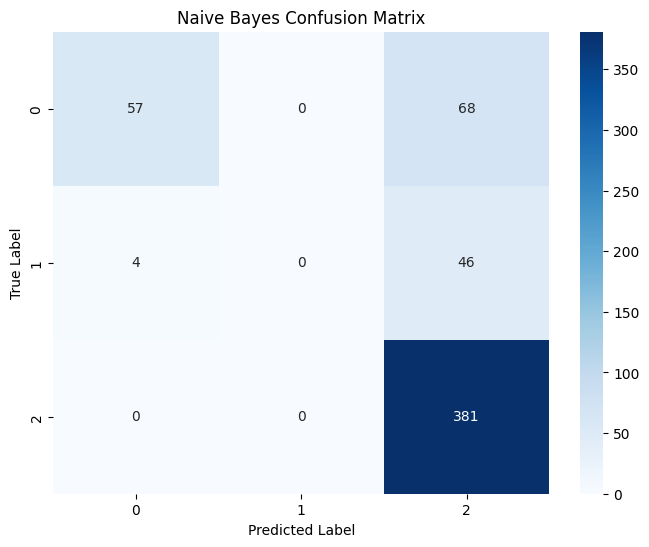


Decision Tree Classifier Results:
Accuracy: 0.9514388489208633

Classification Report:
              precision    recall  f1-score   support

          -1       0.94      0.94      0.94       125
           0       0.91      0.82      0.86        50
           1       0.96      0.97      0.97       381

    accuracy                           0.95       556
   macro avg       0.94      0.91      0.92       556
weighted avg       0.95      0.95      0.95       556



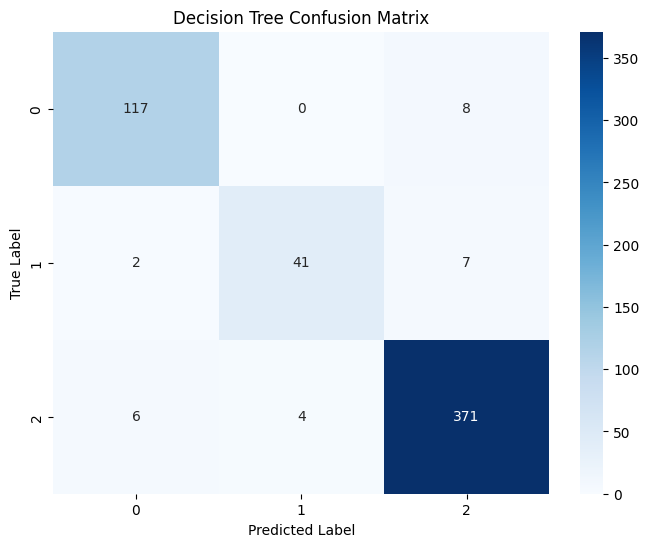


Random Forest Classifier Results:
Accuracy: 0.9586330935251799

Classification Report:
              precision    recall  f1-score   support

          -1       0.95      0.92      0.93       125
           0       1.00      0.82      0.90        50
           1       0.96      0.99      0.97       381

    accuracy                           0.96       556
   macro avg       0.97      0.91      0.94       556
weighted avg       0.96      0.96      0.96       556



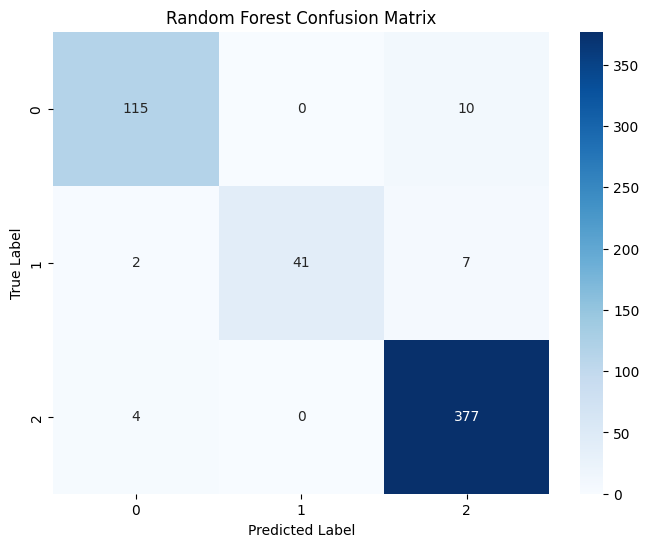

Review: The camera quality is amazing and the battery life is impressive!
Predicted Sentiment: Positive

Review: The product was okay, but the delivery was late.
Predicted Sentiment: Negative

Review: I am very disappointed with the purchase. It broke within a week.
Predicted Sentiment: Negative



In [42]:
X = df['cleaned_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

classifiers = {
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, clf in classifiers.items():
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)

    print(f"\n{name} Classifier Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def predict_sentiment_tfidf(reviews, vectorizer, classifier):
    reviews_tfidf = vectorizer.transform(reviews)

    predictions = classifier.predict(reviews_tfidf)

    sentiment_map = {1: "Positive", 0: "Neutral", -1: "Negative"}

    for review, pred in zip(reviews, predictions):
        print(f"Review: {review}")
        print(f"Predicted Sentiment: {sentiment_map[pred]}\n")

# Example usage
new_reviews = [
    "The camera quality is amazing and the battery life is impressive!",
    "The product was okay, but the delivery was late.",
    "I am very disappointed with the purchase. It broke within a week."
]

best_model = classifiers['Decision Tree']
predict_sentiment_tfidf(new_reviews, tfidf_vectorizer, best_model)

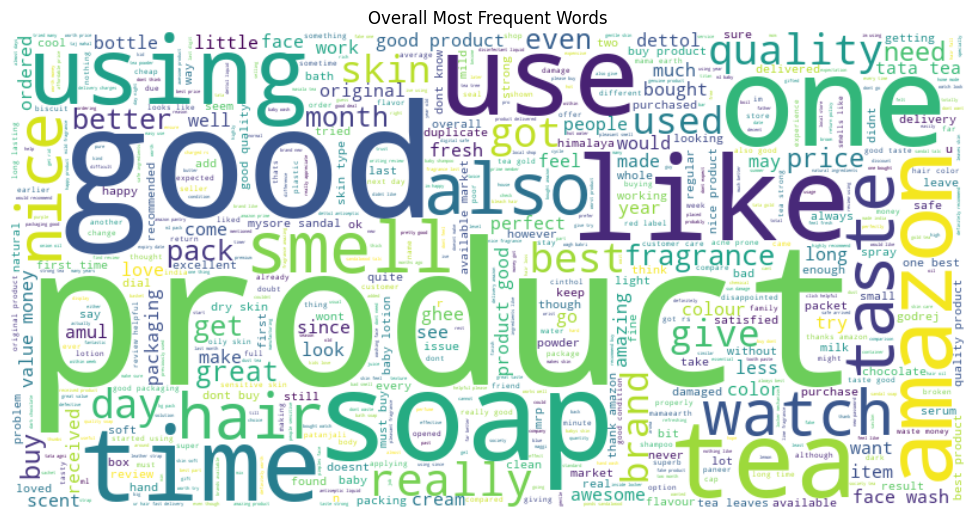

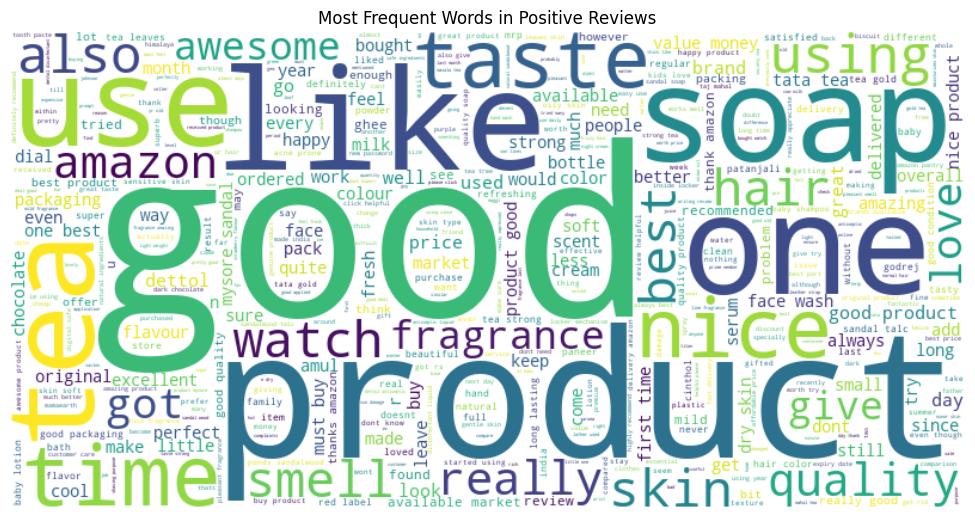

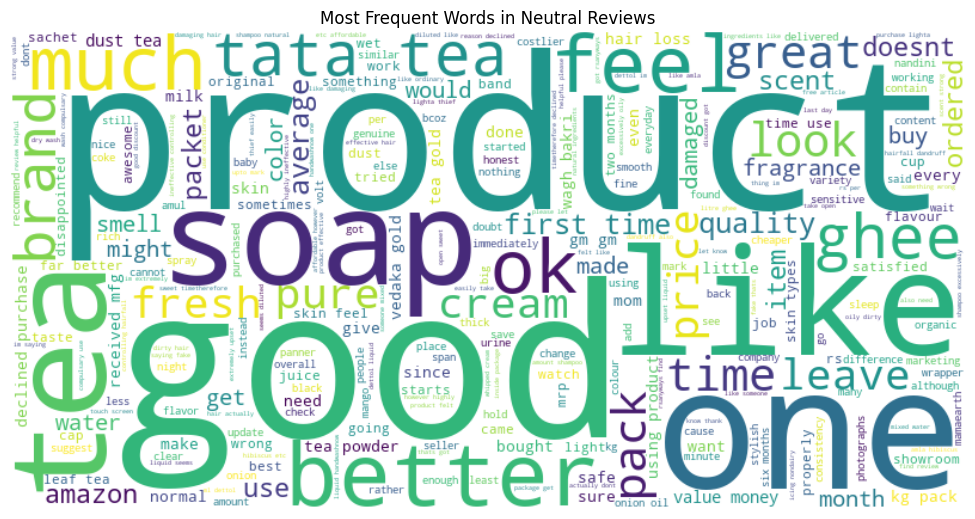

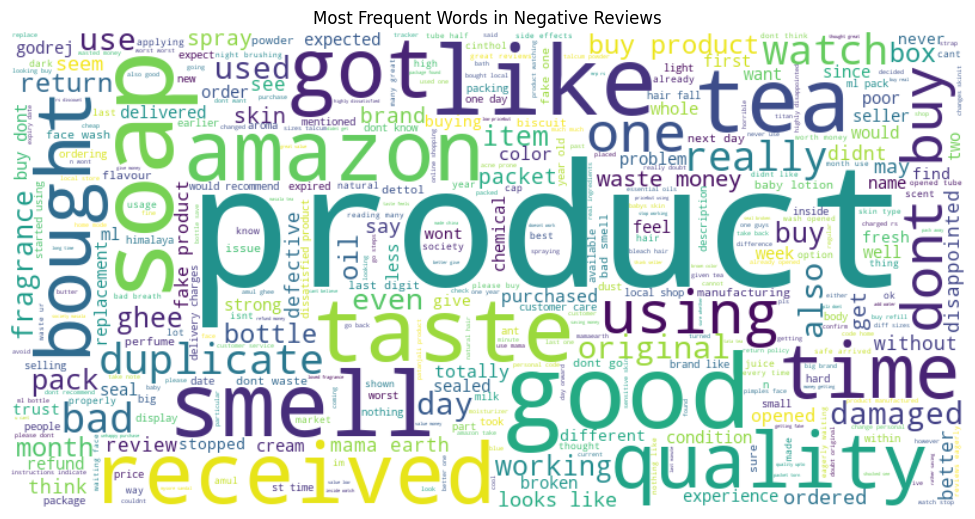

In [27]:
def generate_wordcloud(text_series, title, sentiment_type=None):
    """
    Generate a WordCloud visualization for a given text series.
    
    :param text_series: Pandas Series of text data
    :param title: Title for the WordCloud plot
    :param sentiment_type: Optional filter for specific sentiment type
    """
    if sentiment_type is not None:
        text_series = text_series[df['sentiment'] == sentiment_type]
    
    text = ' '.join(text_series)
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        stopwords=stop_words,
        max_words=50000,
        colormap='viridis'
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

generate_wordcloud(df['cleaned_review'], 'Overall Most Frequent Words')

# WordCloud for Positive Reviews
generate_wordcloud(df['cleaned_review'], 'Most Frequent Words in Positive Reviews', sentiment_type=1)

# WordCloud for Neutral Reviews
generate_wordcloud(df['cleaned_review'], 'Most Frequent Words in Neutral Reviews', sentiment_type=0)

# WordCloud for Negative Reviews
generate_wordcloud(df['cleaned_review'], 'Most Frequent Words in Negative Reviews', sentiment_type=-1)

In [18]:
df.to_csv("output_with_sentiments.csv", index=False)
print("Results saved to output_with_sentiments.csv")


Results saved to output_with_sentiments.csv


# EXAMPLE USAGE

In [ ]:
# Example usage
new_reviews = [
    "The camera quality is amazing and the battery life is impressive!",
    "The product was okay, but the delivery was late.",
    "I am very disappointed with the purchase. It broke within a week."
]

best_model = classifiers['Decision Tree'] # Other options: 'Naive Bayes', 'Random Forest'
predict_sentiment_tfidf(new_reviews, tfidf_vectorizer, best_model)

Review: The camera quality is amazing and the battery life is impressive!
Predicted Sentiment: Positive

Review: The product was okay, but the delivery was late.
Predicted Sentiment: Negative

Review: I am very disappointed with the purchase. It broke within a week.
Predicted Sentiment: Negative



C:\Users\kisla\AppData\Local\Temp\ipykernel_14088\2581795278.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_trends = df.resample('M', on='date')['bert_sentiment'].mean().reset_index()


Monthly Sentiment Trends:
         date  bert_sentiment
0  2015-04-30        0.500000
1  2015-05-31        0.000000
2  2015-06-30             NaN
3  2015-07-31             NaN
4  2015-08-31             NaN
..        ...             ...
62 2020-06-30        0.763889
63 2020-07-31        0.666667
64 2020-08-31        0.580000
65 2020-09-30        0.670886
66 2020-10-31        0.823529

[67 rows x 2 columns]

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:         bert_sentiment   No. Observations:                   67
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   4.699
Date:                Sun, 01 Dec 2024   AIC                             -3.398
Time:                        19:31:07   BIC                              3.171
Sample:                             0   HQIC                            -0.802
                                 - 67                                         
Covariance Type:

C:\Users\kisla\AppData\Local\Temp\ipykernel_14088\2581795278.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date, periods=forecast_steps+1, freq='M')[1:]


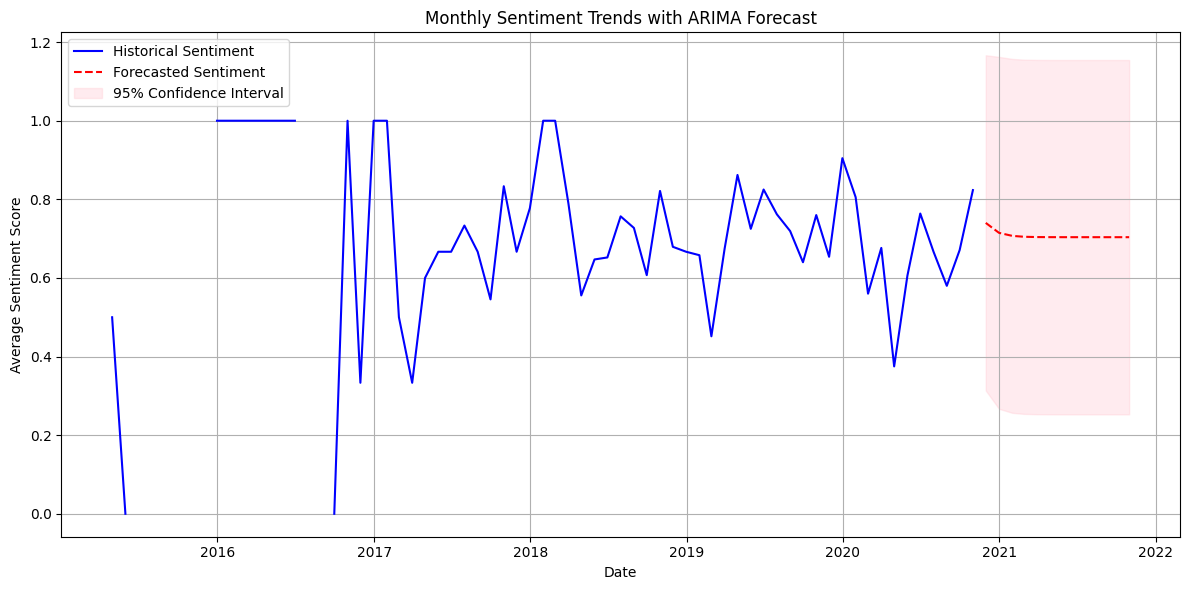


Forecast for Next 12 Months:
         date  forecasted_sentiment
67 2020-11-30              0.740086
68 2020-12-31              0.714757
69 2021-01-31              0.707068
70 2021-02-28              0.704734
71 2021-03-31              0.704026
72 2021-04-30              0.703811
73 2021-05-31              0.703746
74 2021-06-30              0.703726
75 2021-07-31              0.703720
76 2021-08-31              0.703718
77 2021-09-30              0.703717
78 2021-10-31              0.703717


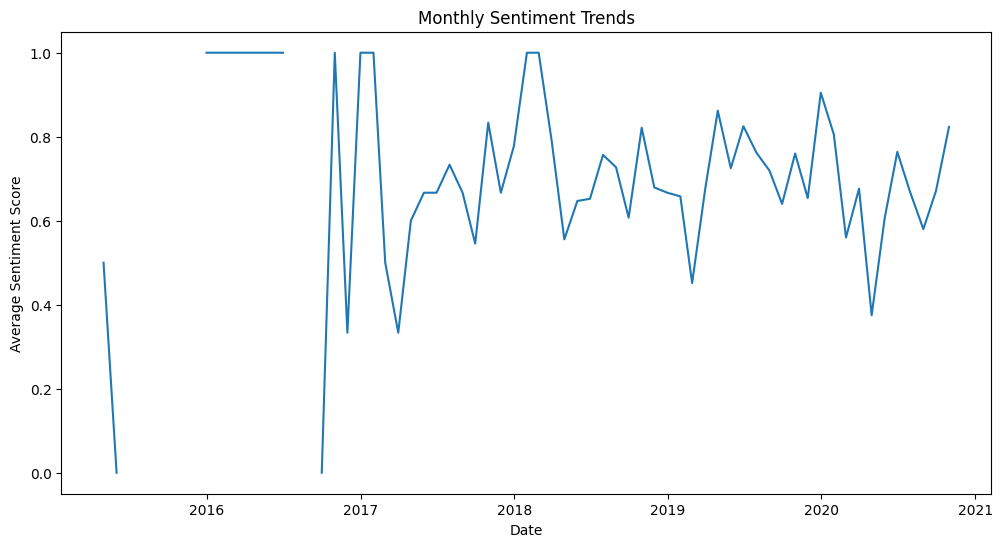

In [ ]:
df['date'] = pd.to_datetime(df['date'])

monthly_trends = df.resample('M', on='date')['bert_sentiment'].mean().reset_index()

print("Monthly Sentiment Trends:")
print(monthly_trends)

if len(monthly_trends) < 10:
    print("Warning: Not enough data points for reliable ARIMA forecasting")
else:
    try:
        model = ARIMA(monthly_trends['bert_sentiment'], order=(1, 1, 1))
        model_fit = model.fit()

        print("\nARIMA Model Summary:")
        print(model_fit.summary())

        # Forecast next 12 months
        forecast_steps = 12
        forecast = model_fit.forecast(steps=forecast_steps)

        last_date = monthly_trends['date'].iloc[-1]
        forecast_dates = pd.date_range(start=last_date, periods=forecast_steps+1, freq='M')[1:]
        forecast_df = pd.DataFrame({
            'date': forecast_dates,
            'forecasted_sentiment': forecast
        })

        plt.figure(figsize=(12, 6))
        
        plt.plot(monthly_trends['date'], monthly_trends['bert_sentiment'], 
                 label='Historical Sentiment', color='blue')

        plt.plot(forecast_df['date'], forecast_df['forecasted_sentiment'], 
                 label='Forecasted Sentiment', color='red', linestyle='--')

        try:
            forecast_ci = model_fit.get_forecast(steps=forecast_steps)
            conf_int = forecast_ci.conf_int()

            conf_int_array = conf_int.to_numpy() if hasattr(conf_int, 'to_numpy') else np.array(conf_int)

            plt.fill_between(
                forecast_dates, 
                conf_int_array[:, 0], 
                conf_int_array[:, 1], 
                color='pink', 
                alpha=0.3, 
                label='95% Confidence Interval'
            )
        except Exception as ci_error:
            print("Could not plot confidence interval:", ci_error)

        plt.title('Monthly Sentiment Trends with ARIMA Forecast')
        plt.xlabel('Date')
        plt.ylabel('Average Sentiment Score')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print("\nForecast for Next 12 Months:")
        print(forecast_df)

    except Exception as model_error:
        print("Error in ARIMA modeling:", model_error)
        print("Suggestion: Try different ARIMA order or check data preprocessing")

if 'monthly_trends' in locals():
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_trends['date'], monthly_trends['bert_sentiment'])
    plt.title('Monthly Sentiment Trends')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.show()